In [1]:
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
#from tqdm import tqdm  # For progress bar
from ABM_Final_Final_Final import SocialNetwork

In [2]:
# We define our variables and bounds
problem = {
    'num_vars': 2,
    'names': ['prob', 'social'],
    'bounds': [[0., 1.], [0.,0.5]]
}



# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 15
max_steps = 500
distinct_samples = 512

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)

# Initialize DataFrame to store results
num_samples = len(param_values) * replicates

data = pd.DataFrame(index=range(num_samples), columns=['prob', 'social'])

data['Run'], data['max IN degree'], data['avg clustering coeff'], data['modularity'] = None, None, None, None

print(data)
# https://stackoverflow.com/questions/67750857/how-to-activate-conda-environment-in-vs-code


      prob social   Run max IN degree avg clustering coeff modularity
0      NaN    NaN  None          None                 None       None
1      NaN    NaN  None          None                 None       None
2      NaN    NaN  None          None                 None       None
3      NaN    NaN  None          None                 None       None
4      NaN    NaN  None          None                 None       None
...    ...    ...   ...           ...                  ...        ...
30715  NaN    NaN  None          None                 None       None
30716  NaN    NaN  None          None                 None       None
30717  NaN    NaN  None          None                 None       None
30718  NaN    NaN  None          None                 None       None
30719  NaN    NaN  None          None                 None       None

[30720 rows x 6 columns]


C:\Users\tiefo\AppData\Local\Temp\ipykernel_11484\3378063465.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)


In [3]:
# Define your model
def run_model(count, params, max_steps):
    prob, social = params
    n_agents = 75
    w_pop = 0.15
    w_prox= 0.75
    w_sim = 0.1
    model = SocialNetwork(n_agents, prob, w_pop, w_prox, w_sim, social)
    for k in range(max_steps + 1):
        model.step()
        print(f"\rProgress: {(k / max_steps) * 100:.2f}%", end='', flush=True)
   
    df_results = pd.DataFrame(model.Data_Collector)
    
    return count, params,  df_results['avg clustering coeff'].iloc[-1], df_results['max IN degrees'].iloc[-1], df_results['modularity'].iloc[-1]

In [4]:
n_jobs = -1
count = 0

# Prepare a list to collect results
results = []

for i in range(replicates):
    with Parallel(n_jobs=n_jobs) as parallel:
        # Add progress bar
        parallel_results = parallel(
            delayed(run_model)(count + idx, vals, max_steps) 
            for idx, vals in enumerate(tqdm(param_values, desc=f"Replicate {i+1}/{replicates}"))
        )
    # Collect results
    results.extend(parallel_results)
    count += len(param_values)

# Save results to DataFrame

    #data.loc[run_id] = vals + [run_id, clustering_coeff, max_in]

# Save DataFrame to CSV
#data.to_csv(f"sobol_rep{replicates}_maxstep{max_steps}_distsamples{distinct_samples}.csv", index=False)


Replicate 1/15:   1%|          | 20/2048 [00:00<00:37, 53.99it/s]

KeyError: 'modularity'

Replicate 1/15:   1%|          | 20/2048 [00:20<00:37, 53.99it/s]

In [53]:
for result in results:
    count = result[0]
    vals = list(result[1])
    clustering_coeff = result[2]
    max_in = result[3]
    modularity = result[4]
    data.at[count, "prob"] = vals[0]
    data.at[count, "social"] = vals[1]
    data.at[count, "n_agents"] = vals[2]
    data.iloc[count, len(vals):len(vals)+4] = count,max_in,clustering_coeff,modularity

print(data)

# Save DataFrame to CSV
data.to_csv(f"sobol_rep{replicates}_maxstep{max_steps}_distsamples{distinct_samples}.csv", index=False)

       prob    social n_agents Run max IN degree avg clustering coeff  \
0   0.09375  0.234375  73.4375   0            24             0.229416   
1   0.65625  0.234375  73.4375   1            47             0.246768   
2   0.09375  0.140625  73.4375   2            23             0.230414   
3   0.09375  0.234375  98.4375   3            33             0.218991   
4   0.65625  0.140625  98.4375   4            69             0.215366   
5   0.59375  0.484375  98.4375   5            52             0.223076   
6   0.15625  0.484375  98.4375   6            34             0.215067   
7   0.59375  0.390625  98.4375   7            50             0.215822   
8   0.59375  0.484375  73.4375   8            44             0.241225   
9   0.15625  0.390625  73.4375   9            24               0.2362   
10  0.84375  0.109375  60.9375  10            47             0.249814   
11  0.90625  0.109375  60.9375  11            54              0.25923   
12  0.84375  0.265625  60.9375  12            47   

In [54]:
Si_cluster = sobol.analyze(problem, data['avg clustering coeff'].values, calc_second_order=False, print_to_console=True)
Si_IN_Degree = sobol.analyze(problem, data['max IN degree'].values, calc_second_order=False, print_to_console=True)
Si_Modularity = sobol.analyze(problem, data['modularity'].values, calc_second_order=False, print_to_console=True)
#max(data['max IN degree'])

                ST   ST_conf
prob      0.156440  0.223061
social    0.297019  0.591471
n_agents  0.590399  1.178663
                S1   S1_conf
prob      0.084890  0.731031
social    0.456563  0.427493
n_agents  0.300705  0.946589
                ST   ST_conf
prob      0.525907  0.290560
social    0.024093  0.037257
n_agents  0.174352  0.190485
                S1   S1_conf
prob      0.912953  0.375300
social    0.052850  0.136468
n_agents  0.320207  0.301169
                ST   ST_conf
prob      0.417666  1.821821
social    0.812874  3.164098
n_agents  0.994996  1.639593
                S1   S1_conf
prob      0.233287  1.020853
social    0.323803  1.401998
n_agents  0.250067  1.465491


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a 

In [55]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

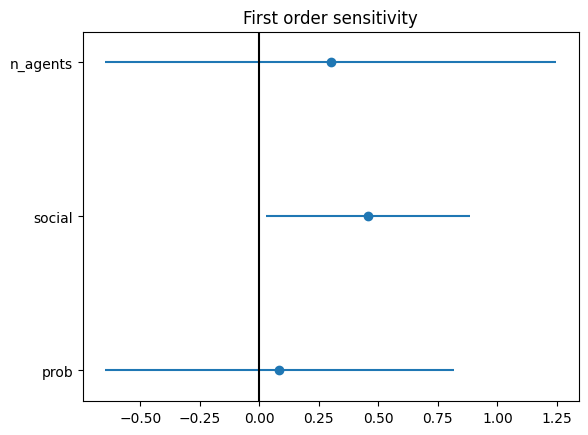

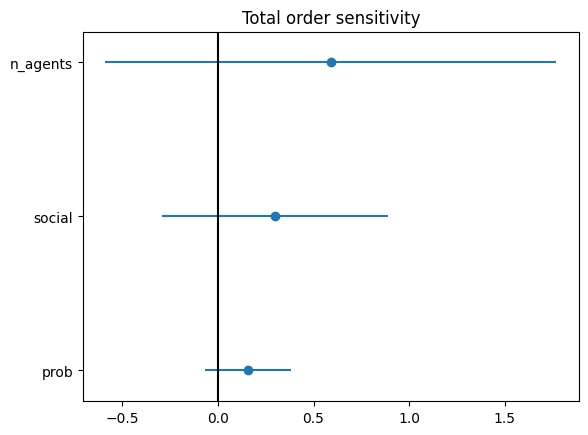

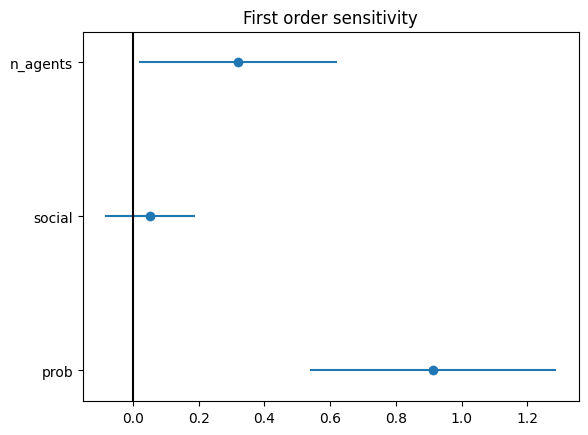

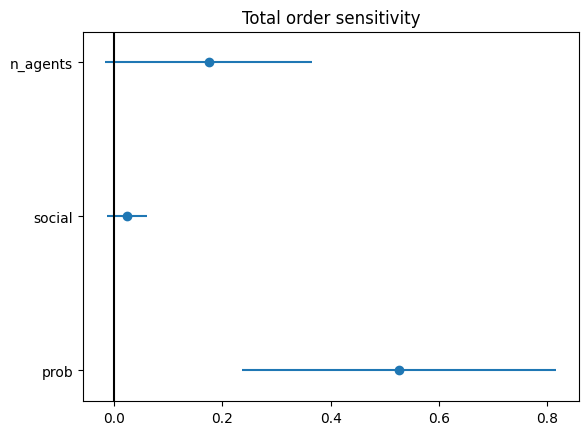

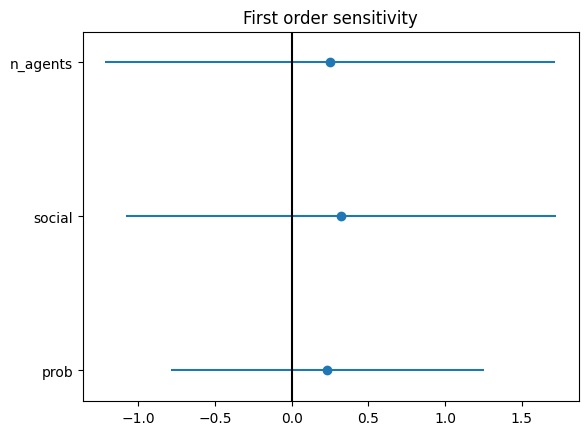

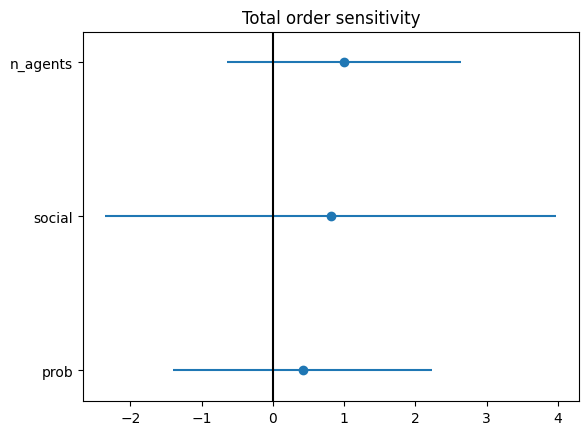

In [57]:
for Si in (Si_cluster, Si_IN_Degree, Si_Modularity):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()